imports setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

sns.set(style = "whitegrid", font_scale = 1.2)

Load and inspect dataset

In [2]:
si_path = "C:/Users/nalaw/OneDrive/Desktop/BIPV_NEW/Clear_CTO_Glass_Baseline.xlsx"
tandem_path = "C:/Users/nalaw/OneDrive/Desktop/BIPV_NEW/CTO_ISO_Solar_Simulator_901_Data_Tandem.xlsx"

df_si = pd.read_excel(si_path)
df_tandem = pd.read_excel(tandem_path)

print("Dataset loaded successfully")
print("Si Dataset shape:", df_si.shape)
display(df_si.head())

print("Tandem Dataset shape:", df_tandem.shape)
display(df_tandem.head())

Dataset loaded successfully
Si Dataset shape: (259, 6)


,Coordinate,R,G,B,A,Jph
0,A10,119,163,97,214.0,9.069595
1,A11,242,167,87,184.0,12.490928
2,A12,124,108,144,143.0,21.798266
3,A13,49,113,184,97.0,23.159105
4,A14,86,61,150,71.0,22.942077


Tandem Dataset shape: (259, 7)


,Coordinate,R,G,B,A,Jph_Top,Jph_Bot
0,A10,119,163,97,214.0,6.715413,2.936559
1,A11,242,167,87,184.0,8.487611,4.778314
2,A12,124,108,144,143.0,13.270762,9.867231
3,A13,49,113,184,97.0,13.620638,10.965296
4,A14,86,61,150,71.0,13.417333,10.932426


Feature and Target Separation

In [3]:
#Si Dataset
x_si = df_si[['R','G','B','A']]
y_si = df_si['Jph']

#Tandem Dataset
x_tandem = df_tandem[['R','G','B','A']]
y_tandem_top = df_tandem['Jph_Top']
y_tandem_bot = df_tandem['Jph_Bot']

#Scaling
scaler_si = StandardScaler()
scaler_tandem = StandardScaler()

# Train-test split
X_si_train, X_si_test, y_si_train, y_si_test = train_test_split(x_si, y_si, test_size=0.2, random_state=42)
X_t_train, X_t_test, y_top_train, y_top_test = train_test_split(x_tandem, y_tandem_top, test_size=0.2, random_state=42)
_, _, y_bot_train, y_bot_test = train_test_split(x_tandem, y_tandem_bot, test_size=0.2, random_state=42)

# Scale data
X_si_train_scaled = scaler_si.fit_transform(X_si_train)
X_si_test_scaled = scaler_si.transform(X_si_test)
X_t_train_scaled = scaler_tandem.fit_transform(X_t_train)
X_t_test_scaled = scaler_tandem.transform(X_t_test)

New feature for images

In [4]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2

def predict_image_currents1(image_path, model_type="si"):
    """
    Predicts Jph or Jph_Top/Bot for every pixel in the image.
    model_type: "si" or "tandem"
    """

    # ----- Load and preprocess image -----
    img = Image.open(image_path).convert("RGBA")
    img_array = np.array(img)
    h, w, _ = img_array.shape
    print(f"\n📸 Image loaded: {image_path}")
    print(f"Dimensions: {w}x{h} pixels")

    # Reshape into (n_pixels, 4)
    pixels = img_array.reshape(-1, 4)
    pixel_df = pd.DataFrame(pixels, columns=['R', 'G', 'B', 'A'])

    # ----- Predict -----
    if model_type.lower() == "si":
        X_scaled = scaler_si.transform(pixel_df)
        jph_preds = model_si.predict(X_scaled)
        jph_map = jph_preds.reshape(h, w)

        plt.imshow(jph_map, cmap="plasma")
        plt.colorbar(label="Predicted Jph (mA/cm²)")
        plt.title("Silicon Current Density Map")
        plt.show()

        print(f"\n🔹 Average Jph: {np.mean(jph_preds):.3f} mA/cm²")

    elif model_type.lower() == "tandem":
        X_scaled = scaler_tandem.transform(pixel_df)
        jph_top = model_top.predict(X_scaled)
        jph_bot = model_bot.predict(X_scaled)

        jph_top_map = jph_top.reshape(h, w)
        jph_bot_map = jph_bot.reshape(h, w)
        jph_limiting = np.minimum(jph_top_map, jph_bot_map)

        # Display heatmaps
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        im1 = axs[0].imshow(jph_top_map, cmap="plasma")
        axs[0].set_title("Top Cell Jph (mA/cm²)")
        fig.colorbar(im1, ax=axs[0], fraction=0.046)

        im2 = axs[1].imshow(jph_bot_map, cmap="plasma")
        axs[1].set_title("Bottom Cell Jph (mA/cm²)")
        fig.colorbar(im2, ax=axs[1], fraction=0.046)

        im3 = axs[2].imshow(jph_limiting, cmap="inferno")
        axs[2].set_title("Series-Limiting Jph (mA/cm²)")
        fig.colorbar(im3, ax=axs[2], fraction=0.046)

        plt.tight_layout()
        plt.show()

        print(f"\n🔹 Average Jph_Top: {np.mean(jph_top):.3f} mA/cm²")
        print(f"🔹 Average Jph_Bot: {np.mean(jph_bot):.3f} mA/cm²")
        print(f"⚡ Average Series-Limiting Jph: {np.mean(np.minimum(jph_top, jph_bot)):.3f} mA/cm²")

    else:
        print("Invalid model_type. Use 'si' or 'tandem'.")


Model Training

In [5]:
model_si = RandomForestRegressor(n_estimators=200, random_state=42)
model_top = RandomForestRegressor(n_estimators=200, random_state=42)
model_bot = RandomForestRegressor(n_estimators=200, random_state=42)

model_si.fit(X_si_train_scaled, y_si_train)
model_top.fit(X_t_train_scaled, y_top_train)
model_bot.fit(X_t_train_scaled, y_bot_train)

print("✅ Models trained successfully!")

✅ Models trained successfully!


Evaluate Model

In [6]:
# Step 5: Model Evaluation

def evaluate_model(y_true, y_pred, name="Model"):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"\n📊 {name} Evaluation Metrics:")
    print(f"R² Score   : {r2:.4f}")
    print(f"MAE        : {mae:.4f}")
    print(f"RMSE       : {rmse:.4f}")
    return {"Model": name, "R²": r2, "MAE": mae, "RMSE": rmse}

# Predictions
y_si_pred = model_si.predict(X_si_test_scaled)
y_top_pred = model_top.predict(X_t_test_scaled)
y_bot_pred = model_bot.predict(X_t_test_scaled)

# Evaluate
results = []
results.append(evaluate_model(y_si_test, y_si_pred, "Silicon"))
results.append(evaluate_model(y_top_test, y_top_pred, "Tandem Top"))
results.append(evaluate_model(y_bot_test, y_bot_pred, "Tandem Bottom"))



📊 Silicon Evaluation Metrics:
R² Score   : 0.9657
MAE        : 0.9707
RMSE       : 1.2748

📊 Tandem Top Evaluation Metrics:
R² Score   : 0.9523
MAE        : 0.5362
RMSE       : 0.7121

📊 Tandem Bottom Evaluation Metrics:
R² Score   : 0.9702
MAE        : 0.5353
RMSE       : 0.7085


Visualization

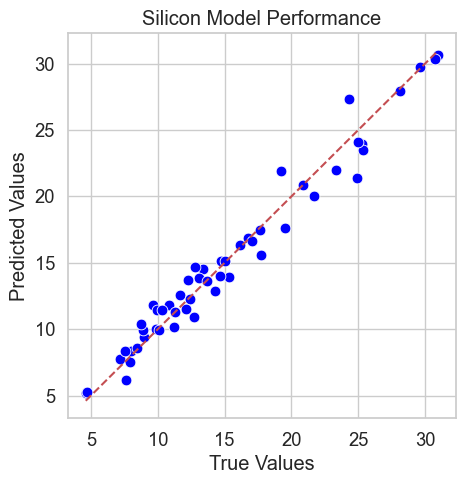

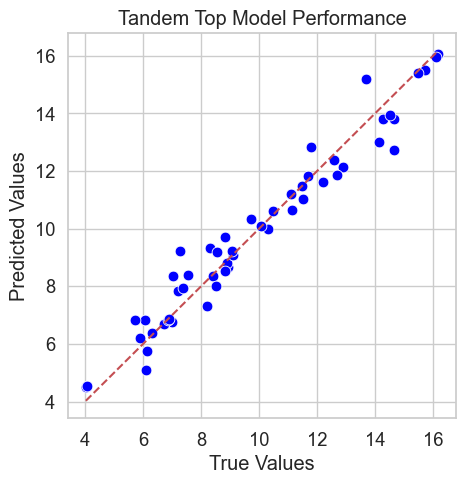

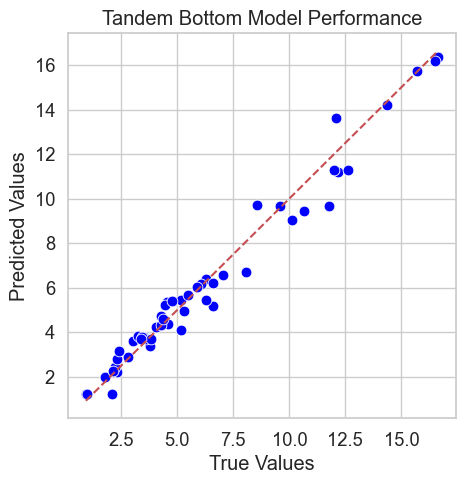

In [7]:
def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(5,5))
    sns.scatterplot(x=y_true, y=y_pred, color='blue', s=60)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_results(y_si_test, y_si_pred, "Silicon Model Performance")
plot_results(y_top_test, y_top_pred, "Tandem Top Model Performance")
plot_results(y_bot_test, y_bot_pred, "Tandem Bottom Model Performance")

Feature Importance

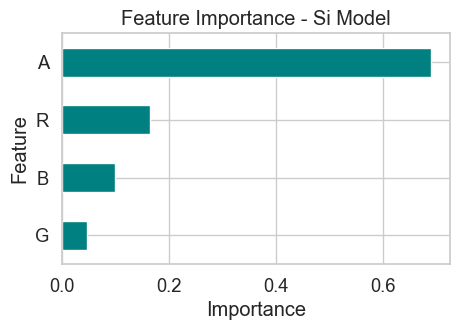

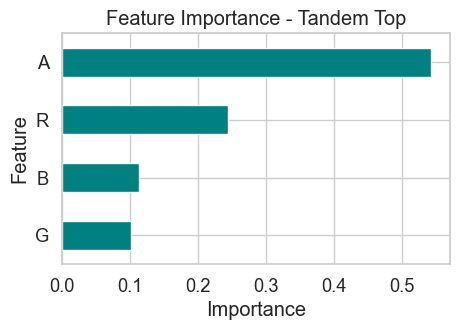

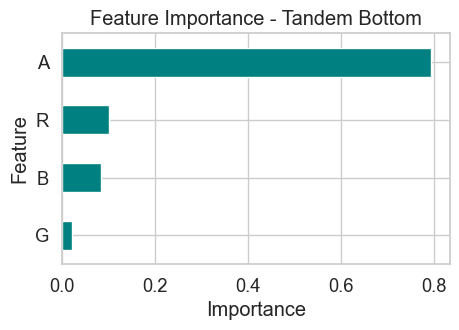

In [8]:
def plot_feature_importance(model, feature_names, title):
    importance = pd.Series(model.feature_importances_, index=feature_names)
    importance.sort_values().plot(kind='barh', figsize=(5,3), color='teal')
    plt.title(title)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

plot_feature_importance(model_si, x_si.columns, "Feature Importance - Si Model")
plot_feature_importance(model_top, x_tandem.columns, "Feature Importance - Tandem Top")
plot_feature_importance(model_bot, x_tandem.columns, "Feature Importance - Tandem Bottom")


Save Model and Scalar

In [9]:
joblib.dump(model_si, "model_si.pkl")
joblib.dump(model_top, "model_tandem_top.pkl")
joblib.dump(model_bot, "model_tandem_bot.pkl")
joblib.dump(scaler_si, "scaler_si.pkl")
joblib.dump(scaler_tandem, "scaler_tandem.pkl")

print("✅ Models and scalers saved successfully!")


✅ Models and scalers saved successfully!


Prediction

In [10]:
import numpy as np

# ================== INTERACTIVE TERMINAL SECTION ==================

if __name__ == "__main__":
    import sys

    # Force terminal interaction (works both in Jupyter and when run as .py)
    print("\n🔸 Choose model type:")
    print("1. Silicon (Single-Junction)")
    print("2. Tandem (Top & Bottom)")

    try:
        choice = input("Enter 1 or 2: ").strip()

        print("\n🔸 Enter RGBA values (0–255):")
        R = float(input("R: "))
        G = float(input("G: "))
        B = float(input("B: "))
        A = float(input("A: "))

        user_input = np.array([[R, G, B, A]])

        if choice == "1":
            X_scaled = scaler_si.transform(user_input)
            jph_pred = model_si.predict(X_scaled)[0]
            print(f"\n🔹 Predicted Jph (Silicon): {jph_pred:.3f} mA/cm²")

        elif choice == "2":
            X_scaled = scaler_tandem.transform(user_input)
            jph_top = model_top.predict(X_scaled)[0]
            jph_bot = model_bot.predict(X_scaled)[0]
            print(f"\n🔹 Predicted Jph_Top: {jph_top:.3f} mA/cm²")
            print(f"🔹 Predicted Jph_Bot: {jph_bot:.3f} mA/cm²")
            print(f"⚡ Current-limiting Jph (series tandem): {min(jph_top, jph_bot):.3f} mA/cm²")

        else:
            print("Invalid choice. Please restart and enter 1 or 2.")

    except KeyboardInterrupt:
        print("\n\n❌ Exiting by user interrupt.")
        sys.exit(0)

    except Exception as e:
        print(f"\n⚠️ Error: {e}")



🔸 Choose model type:
1. Silicon (Single-Junction)
2. Tandem (Top & Bottom)

🔸 Enter RGBA values (0–255):

🔹 Predicted Jph (Silicon): 28.414 mA/cm²


c:\Users\nalaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔸 Choose model type:
1. Silicon (Single-Junction)
2. Tandem (Top & Bottom)

📸 Image loaded: C:/Users/nalaw/OneDrive/Desktop/BIPV_NEW/CJ.png
Dimensions: 470x594 pixels


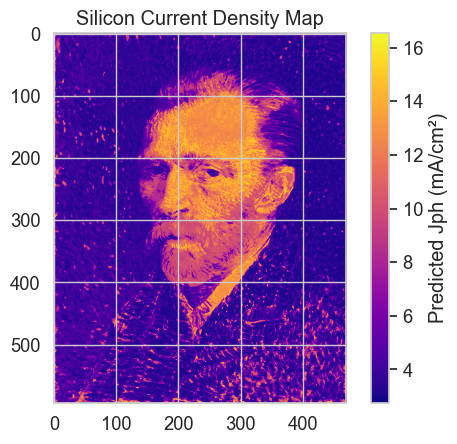


🔹 Average Jph: 5.784 mA/cm²


In [11]:
print("\n🔸 Choose model type:")
print("1. Silicon (Single-Junction)")
print("2. Tandem (Top & Bottom)")
choice = input("Enter 1 or 2: ").strip()

image_path = 'C:/Users/nalaw/OneDrive/Desktop/BIPV_NEW/CJ.png'

if choice == "1":
    predict_image_currents1(image_path, model_type="si")
elif choice == "2":
    predict_image_currents1(image_path, model_type="tandem")
else:
    print("Invalid choice.")


Avg Current

In [35]:
def predict_image_currents(image_path, model_type="si", opacity=100):
    """
    Predicts Jph or Jph_Top/Bot for every pixel in the image,
    calculates average current, and allows controlling opacity.
    
    opacity: 0-100% (0 = fully transparent, 100 = original alpha)
    """

    # ----- Load and preprocess image -----
    img = Image.open(image_path).convert("RGBA")
    img_array = np.array(img)
    h, w, _ = img_array.shape
    print(f"\n📸 Image loaded: {image_path}")
    print(f"Dimensions: {w}x{h} pixels")

    # Adjust opacity
    alpha_scaled = (img_array[:, :, 3] * (opacity / 100)).astype(np.uint8)
    img_array_opacity = img_array.copy()
    img_array_opacity[:, :, 3] = alpha_scaled

    # Display opacity-adjusted image with transparent background
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_facecolor('none')  # Transparent background
    fig.patch.set_alpha(0)    # Transparent figure background
    ax.imshow(img_array_opacity)
    ax.set_title(f"Image with Opacity {opacity}%")
    ax.axis("off")
    plt.show()

    # ----- Prepare for prediction -----
    pixels = img_array_opacity.reshape(-1, 4)
    pixel_df = pd.DataFrame(pixels, columns=['R', 'G', 'B', 'A'])
    
    # Filter out fully transparent pixels (alpha = 0) but keep semi-transparent ones
    non_transparent_mask = pixel_df['A'] > 0
    pixel_df_filtered = pixel_df[non_transparent_mask].copy()
    
    print(f"🔍 Non-transparent pixels: {non_transparent_mask.sum()} / {len(pixel_df)}")

    # ----- Predict -----
    if model_type.lower() == "si":
        X_scaled = scaler_si.transform(pixel_df_filtered)
        jph_preds = model_si.predict(X_scaled)
        
        # Reconstruct full map with NaN for fully transparent pixels
        jph_map_full = np.full((h, w), np.nan)
        jph_map_full[img_array_opacity[:, :, 3] > 0] = jph_preds
        jph_map = jph_map_full

        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_facecolor('none')
        fig.patch.set_alpha(0)
        im = ax.imshow(jph_map, cmap="plasma")
        plt.colorbar(im, ax=ax, label="Predicted Jph (mA/cm²)")
        ax.set_title("Silicon Current Density Map")
        plt.show()

        avg_jph = np.nanmean(jph_preds)  # Use nanmean to ignore NaN values
        print(f"\n🔹 Average Jph across image: {avg_jph:.3f} mA/cm²")
        return jph_map, avg_jph

    elif model_type.lower() == "tandem":
        X_scaled = scaler_tandem.transform(pixel_df_filtered)
        jph_top = model_top.predict(X_scaled)
        jph_bot = model_bot.predict(X_scaled)

        # Reconstruct full maps with NaN for fully transparent pixels
        jph_top_full = np.full((h, w), np.nan)
        jph_bot_full = np.full((h, w), np.nan)
        
        jph_top_full[img_array_opacity[:, :, 3] > 0] = jph_top
        jph_bot_full[img_array_opacity[:, :, 3] > 0] = jph_bot
        
        jph_top_map = jph_top_full
        jph_bot_map = jph_bot_full
        jph_limiting = np.minimum(jph_top_map, jph_bot_map)

        # Display heatmaps with transparent background
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        fig.patch.set_alpha(0)
        
        for ax in axs:
            ax.set_facecolor('none')
        
        im1 = axs[0].imshow(jph_top_map, cmap="plasma")
        axs[0].set_title("Top Cell Jph (mA/cm²)")
        fig.colorbar(im1, ax=axs[0], fraction=0.046)

        im2 = axs[1].imshow(jph_bot_map, cmap="plasma")
        axs[1].set_title("Bottom Cell Jph (mA/cm²)")
        fig.colorbar(im2, ax=axs[1], fraction=0.046)

        im3 = axs[2].imshow(jph_limiting, cmap="inferno")
        axs[2].set_title("Series-Limiting Jph (mA/cm²)")
        fig.colorbar(im3, ax=axs[2], fraction=0.046)

        plt.tight_layout()
        plt.show()

        avg_top = np.nanmean(jph_top)
        avg_bot = np.nanmean(jph_bot)
        avg_limiting = np.nanmean(jph_limiting)
        print(f"\n🔹 Average Jph_Top: {avg_top:.3f} mA/cm²")
        print(f"🔹 Average Jph_Bot: {avg_bot:.3f} mA/cm²")
        print(f"⚡ Average Series-Limiting Jph: {avg_limiting:.3f} mA/cm²")

        return jph_top_map, jph_bot_map, jph_limiting, avg_top, avg_bot, avg_limiting

    else:
        print("Invalid model_type. Use 'si' or 'tandem'.")
        return None


📸 Image loaded: C:/Users/nalaw/OneDrive/Desktop/BIPV_NEW/CJ.png
Dimensions: 470x594 pixels


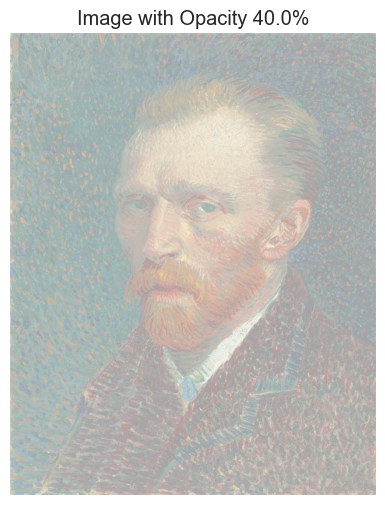

🔍 Non-transparent pixels: 279180 / 279180


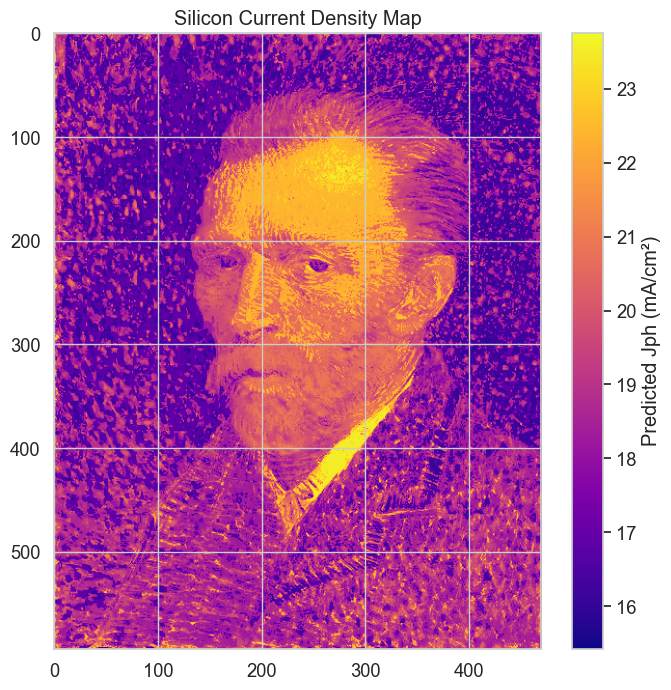


🔹 Average Jph across image: 18.681 mA/cm²


In [36]:
image_path = 'C:/Users/nalaw/OneDrive/Desktop/BIPV_NEW/CJ.png'
choice = input("Choose model (1=Si, 2=Tandem): ").strip()
opacity = float(input("Enter opacity (0-100%): "))

if choice == "1":
    heatmap, avg_jph = predict_image_currents(image_path, model_type="si", opacity=opacity)
elif choice == "2":
    jph_top_map, jph_bot_map, jph_limiting, avg_top, avg_bot, avg_limiting = predict_image_currents(image_path, model_type="tandem", opacity=opacity)